# This sample is used to demonstrate horizontal integration.

### Step 0：Since Jupyter Notebook does not automatically release GPU memory after running, please run this code to clear all processes occupying GPU memory before the FIRST time starting execution.¶

In [1]:
!fuser -v /dev/nvidia* |awk '{for(i=1;i<=NF;i++)print "kill -9 " $i;}' | sh

                     USER        PID ACCESS COMMAND
/dev/nvidia-uvm:     root      mount /dev/nvidia-uvm
                     root      F...m python
/dev/nvidia-uvm-tools:
                     root      mount /dev/nvidia-uvm-tools
/dev/nvidia0:        root      mount /dev/nvidia0
                     root      F...m python
/dev/nvidiactl:      root      mount /dev/nvidiactl
                     root      F...m python
sh: 1: kill: Illegal number: kernel
sh: 2: kill: Illegal number: 630731kernelkernel
sh: 3: kill: Illegal number: 630731kernel


### Step 1 Load packages

In [2]:
import argparse
import os
os.chdir('/remote-home/13186919777/home/STAIG-test')
import warnings
warnings.filterwarnings('ignore')
import random
import yaml
from yaml import SafeLoader
import torch
from staig.adata_processing import LoadBatch10xAdata
import numpy as np
from staig.staig import STAIG
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

### Step 2: Load data and train

In [3]:

file_fold = './Dataset'


args = argparse.Namespace(
    dataset='visium',
    slide='integration_horizontal',
    config='train_img_config.yaml',
    label=False,
    filelist=['Mouse_Brain_Anterior', 'Mouse_Brain_Posterior']
)

config = yaml.load(open(args.config), Loader=SafeLoader)[str(args.slide)]
slide_path = os.path.join(file_fold, args.dataset)

torch.manual_seed(config['seed'])
np.random.seed(config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config['seed'])
    torch.cuda.manual_seed_all(config['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
random.seed(12345)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 
torch.use_deterministic_algorithms(True)
data = LoadBatch10xAdata(dataset_path=slide_path,file_list = args.filelist,n_neighbors=config['num_neigh'],n_top_genes=config['num_gene'],image_emb=False, label = args.label).run()
staig = STAIG(args=args,config=config,single=True,refine=False)    
staig.adata = data
staig.train()
staig.eva()


now load: Mouse_Brain_Anterior
Mouse_Brain_Anterior build local graph done
Mouse_Brain_Anterior added to list
now load: Mouse_Brain_Posterior
Mouse_Brain_Posterior build local graph done
Mouse_Brain_Posterior added to list
load all slices done
merge done


Calculating distances: 100%|██████████| 6050/6050 [00:14<00:00, 428.52it/s]


merge adata load done
=== prepare for training ===
Consider intra slice
=== train ===


100%|██████████| [00:34<00:00,  2.29it/s]


=== load ===
[[ 0.9766139   0.05542142  0.41893669 ...  0.95861461 -0.72032374
  -0.47601244]
 [ 0.85275591  0.17893524  0.44508562 ...  0.58735598 -0.45444434
  -0.16956271]
 [-1.40053942 -0.05368521 -0.756302   ... -1.38298917  1.12685416
   0.58890379]
 ...
 [-1.44014374 -0.13852197 -0.73819015 ... -1.40339942  1.00646544
   0.56889952]
 [-1.11297863 -0.09902454 -0.57341237 ... -1.04429996  0.7159733
   0.48285458]
 [ 0.77499949  0.06447066  0.46208976 ...  0.67551732 -0.66912046
  -0.34140168]]
embedding generated, go clustering


### Step4: Clustering

In [4]:
staig.cluster(args.label)
rgb_values = sns.color_palette("tab20", len(staig.adata.obs['domain'].unique()))
color_fine = dict(zip(list(staig.adata.obs['domain'].unique()), rgb_values))

fitting ...
  |                                                                      |   0%

  |======================================================================| 100%
calculate SC and DB
SC: 0.1396308101236951
DB: 1.5755937472414627
BatchKL= [0.71667203]
Median ILISI: 1.11


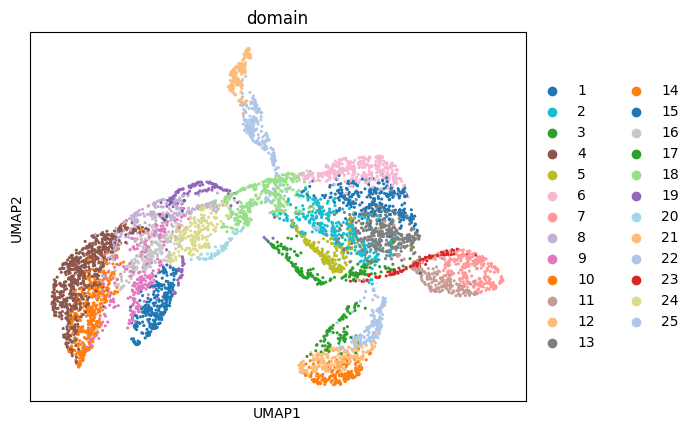

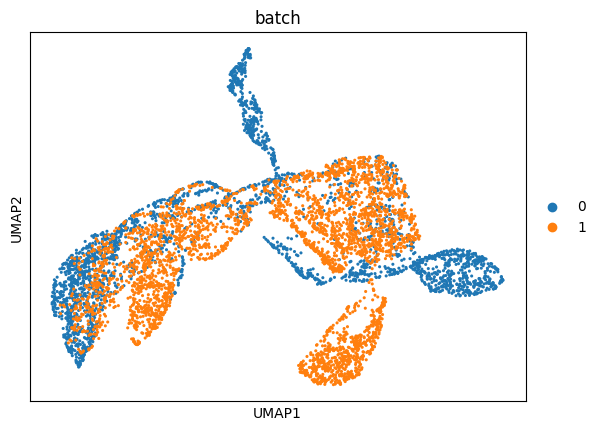

In [5]:
sc.pp.neighbors(staig.adata, use_rep='emb')
sc.tl.umap(staig.adata)
sc.pl.umap(staig.adata, color='domain',palette=color_fine, show=True,save='mouse_domain.pdf')
sc.pl.umap(staig.adata, color='batch', show=True,save='mouse_batch.pdf')

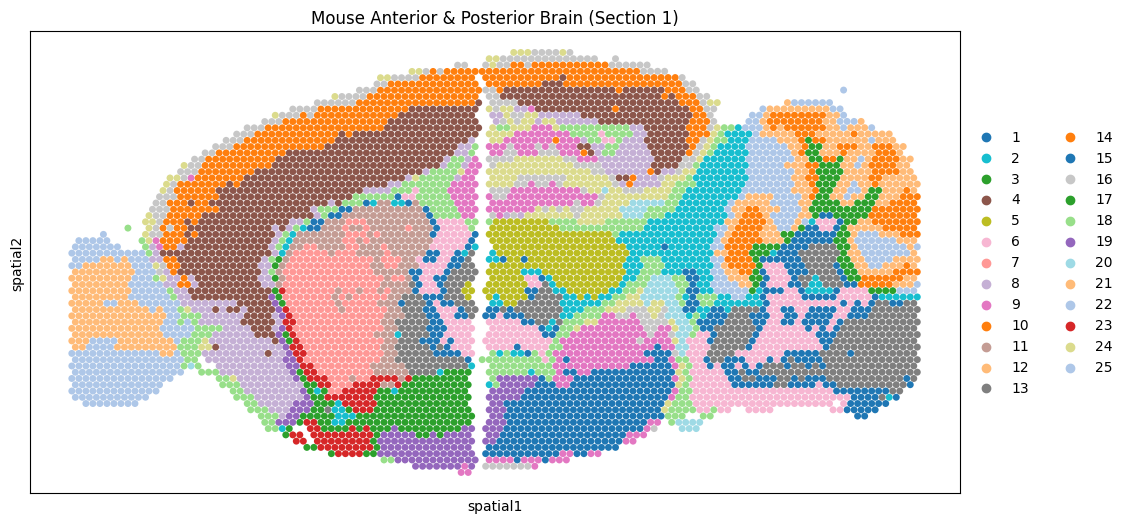

In [6]:
plt.rcParams["figure.figsize"] = (12, 6)
data_all = sc.read_h5ad('./Dataset/9.Mouse_Brain_Merge_Anterior_Posterior_Section_1/filtered_feature_bc_matrix.h5ad') #It merely utilizes already aligned coordinates for better demonstration.
data_all.obsm['spatial'][:,1] = -1*data_all.obsm['spatial'][:,1]
staig.adata.obsm['spatial']=data_all.obsm['spatial']
sc.pl.embedding(staig.adata, basis="spatial",
                    color="domain",save='mouse.pdf',
                    s=100,
                    show=True,
                    palette=color_fine,
                    title='Mouse Anterior & Posterior Brain (Section 1)')

# UMAP

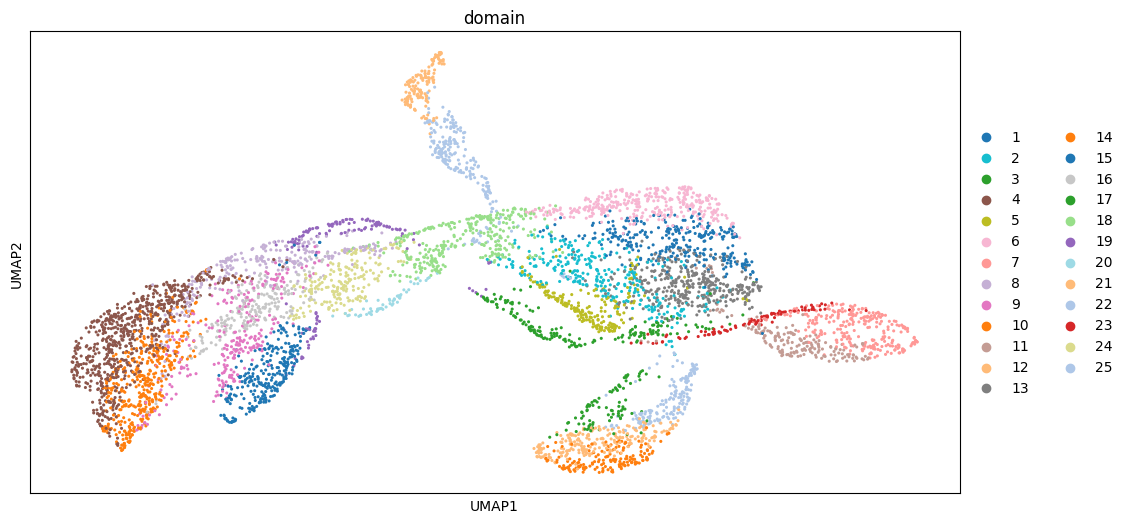

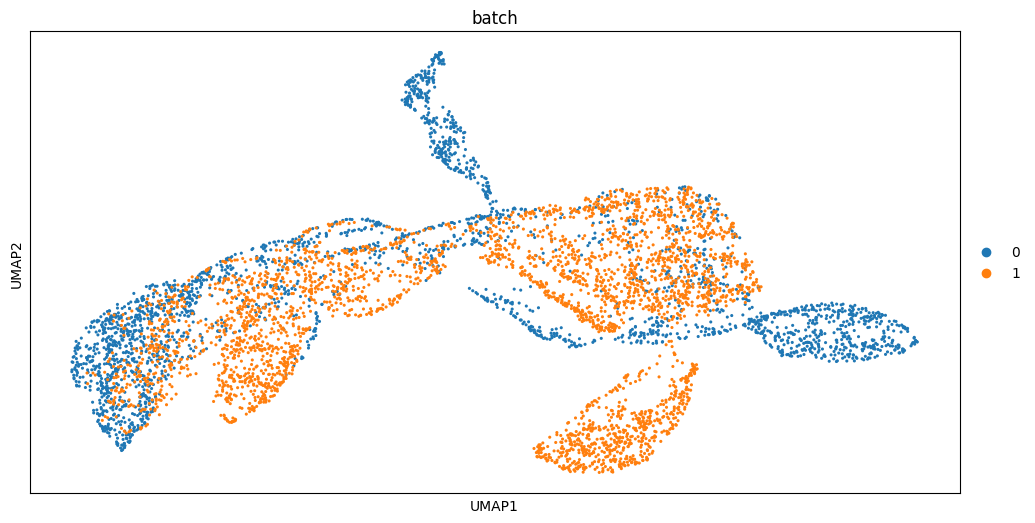

In [7]:
sc.pp.neighbors(staig.adata, use_rep='emb')
sc.tl.umap(staig.adata)
sc.pl.umap(staig.adata, color='domain',palette=color_fine, show=True)
sc.pl.umap(staig.adata, color='batch', show=True)